# Sustainable Heating & Cooling project 

## Task 1
Simulate the Pasta cooking step of the pasta cooker 

#### Data and Package importation: 

In [58]:
from pylab import *
from Compressor_model import recip_comp_SP
from scipy.integrate import odeint
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import CoolProp.CoolProp as CP
import plotDiag_Th_Ts as Diag
import matplotlib.pyplot as plt
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
import pandas as pd

In [12]:
# === Simulation parameters ===
sim_duration = 12 * 3600      # [s] total simulation time (12 h)

# === Pasta cooking parameters ===
m_pasta_batch   = 2.0         # [kg] pasta per batch
m_pasta_basket  = 0.5         # [kg] pasta per basket
n_baskets       = 4.0         # number of pasta baskets
t_env          = 20.0        # [°C] outside temperature
t_p_0           = 7.0         # [°C] initial pasta temperature
t_p_tgt  = 85.0        # [°C] cooking temperature 
t_w_init = 20.0        # [°C] ambient start temperature 
t_w_min     = 85.0        # [°C] lower control bound 
t_w_max     = 93.0        # [°C] upper control bound 
t_cook          = 7 * 60      # [s] cooking time per batch 
t_break         = 5 * 60      # [s] break between batches 

# === Thermal resistances ===
r_env_water   = 30.0          # environment ↔ water 
r_water_pasta = 15.0          # water ↔ pasta 

# === Specific heats ===
cp_water = 4.18            # [kJ/kg/K] water 
cp_pasta = 3.5              # [kJ/kg/K] pasta 

# === Cooker Dimensions ===
W_ext = 0.27 #[m]
L_ext = 0.47 #[m]
W_in = 0.10 #[m]
L_in = 0.20 #[m]
H_ext = 0.20 #[m]
H_in = 0.15 #[m]
wall_thick = 0.02 #[m]

#### Determine the required heating power during the pasta cooking phase

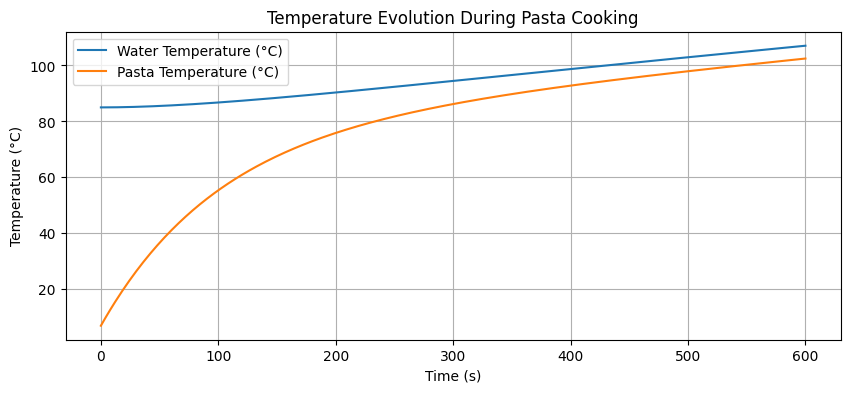

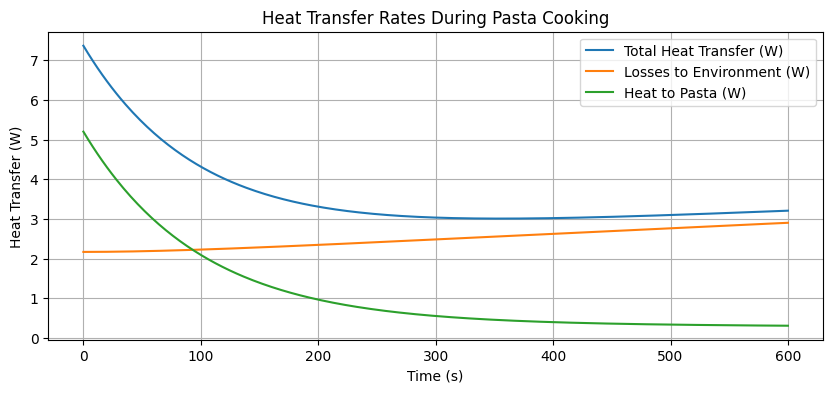

93.95867395033763
99.61350114799622
7.366666666666667
85.0


In [13]:

#calling it with t_w= t_w_min for now
t_w= t_w_min
def required_heating_power(t_w,r_water_pasta,r_env_water,t_p_0,m_pasta_batch,cp_pasta):
    #for now I assume the the cooking température is 85 degrees
    P_loss = (t_w-t_env)/r_env_water
    P_pasta_max = (t_w-t_p_0)/r_water_pasta
    P_peak = P_loss + P_pasta_max
    
    P_pasta = m_pasta_batch*cp_pasta(t_w-t_p_0)
    E_pasta_avg = P_pasta/t_cook

    P_avg = P_pasta+P_loss

    return P_avg, P_peak, E_pasta_avg

#Modelisation of the heating process
mw = 26.6*46.6*19.8*(10**-6)*1000 # [kg] water mass
Qcond = 7.375
def dTdt(t,T):
    Tw,Tp = T
    return [(-1/(mw*cp_water))*((1/r_water_pasta)*(Tw - Tp) + (1/r_env_water)*(Tw - t_env))  + (1/(mw*cp_water))*Qcond,(1/(r_water_pasta*m_pasta_batch*cp_pasta))*(Tw - Tp)]


T0 = (t_w_min,t_p_0)
t = np.linspace(0,10*60,300)
sol = odeint(dTdt, y0 = T0, t=t, tfirst = True)

Tw_sol = sol.T[0]
Tp_sol = sol.T[1]



# Plot temperatures
plt.figure(figsize=(10, 4))
plt.plot(t, Tw_sol, label="Water Temperature (°C)")
plt.plot(t, Tp_sol, label="Pasta Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Evolution During Pasta Cooking")
plt.legend()
plt.grid(True)
plt.show()

# Plot heat transfers
plt.figure(figsize=(10, 4))
plt.plot(t, (1/r_water_pasta)*(Tw_sol - Tp_sol) + (1/r_env_water)*(Tw_sol - t_env), label="Total Heat Transfer (W)")
plt.plot(t, (1/r_env_water)*(Tw_sol - t_env), label="Losses to Environment (W)")
plt.plot(t, (1/r_water_pasta)*(Tw_sol - Tp_sol), label="Heat to Pasta (W)")
plt.xlabel("Time (s)")
plt.ylabel("Heat Transfer (W)")
plt.title("Heat Transfer Rates During Pasta Cooking")
plt.legend()
plt.grid(True)
plt.show()

print(Tp_sol[210])
print(Tw_sol[210])
print((1/r_water_pasta)*(Tw_sol[0] - Tp_sol[0]) + (1/r_env_water)*(Tw_sol[0] - t_env))
print(np.min(Tw_sol))

In [14]:
# le mettre sous la forme d'une fonction 
#all dimensions in [mm]
pipe_diameter = 6.35
lenght_available = 466
height_available = 48
width_available = 266

number_of_pipes = (lenght_available // pipe_diameter) * (height_available // pipe_diameter) 
max_heat_transfer_area = number_of_pipes * (np.pi * pipe_diameter * width_available) / 1000000 # [m^2]
print(f"Max heat transfer area: {max_heat_transfer_area:.2f} m^2, with {number_of_pipes:.0f} pipes")

Max heat transfer area: 2.71 m^2, with 511 pipes


### On-Off strategy

Heating on = 272.0 times, total duration = 12.0 minutes


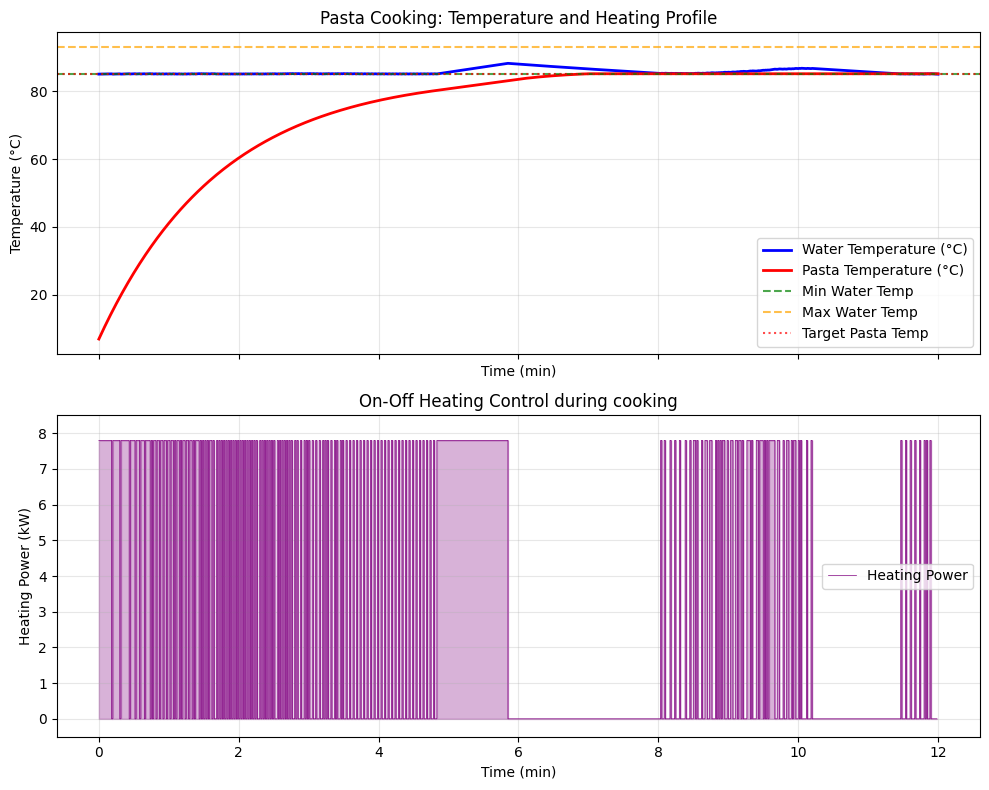


Heating Statistics:
Total cooking time: 12.0 minutes
Heating on time: 4.5 minutes (37.8%)
Total energy consumed: 0.035 kWh
Final pasta temperature: 85.1°C
Final water temperature: 85.0°C
Total energy used: 0.59 kWh


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def optimize_on_off_control_cooking(
    m_w=24.54, c_w=4180.0,  # water mass [kg], heat capacity [J/(kg·K)]
    m_p=2.0, c_p=3500.0,   # pasta mass [kg], heat capacity [J/(kg·K)]
    R_env=30e-3,           # environmental resistance [K/W]
    R_wp=15e-3,            # water↔pasta resistance [K/W]
    T_inf=20.0,            # ambient [°C]
    Tw0=85.0, Tp0=7.0,      # initial temperatures [°C]
    T_w_min=85.0, T_w_max=93.0, T_p_target=85.0,
    P_max=7800.0,          # max heating power [W]
    duration=12*60.0, dt=1.0,  # total time [s], timestep [s]
    t_cook=7*60.0, t_break=5*60.0  # cooking time [s], break time [s]
    ):
    horizon = int(duration / dt)
    
    # Create model
    m = gp.Model("pasta_onoff")
    m.setParam('OutputFlag', 0)

    # Variables
    u = m.addVars(horizon, vtype=GRB.BINARY, name="u")  
    Tw = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tw")
    Tp = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tp")

    # Initial conditions
    m.addConstr(Tw[0] == Tw0, name="init_Tw")
    m.addConstr(Tp[0] == Tp0, name="init_Tp")

    # Dynamics
    for k in range(horizon):
        if k < int(t_cook / dt):
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = (Tw[k] - Tp[k]) / R_wp
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")

            dTp = Q_pasta / (m_p * c_p)
            m.addConstr(Tp[k+1] == Tp[k] + dt * dTp, name=f"dyn_p_{k}")
        else:
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = 0
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")
            m.addConstr(Tp[k+1] == Tp[k] , name=f"dyn_p_{k}")

        m.addConstr(Tw[k] >= T_w_min, name=f"min_Tw_{k}")
        m.addConstr(Tw[k] <= T_w_max, name=f"max_Tw_{k}")

    m.addConstr(Tp[int(t_cook / dt)] >= T_p_target, name="target_Tp")

    m.setObjective(gp.quicksum(u[k] for k in range(horizon)), GRB.MINIMIZE)
    m.optimize()

    u_opt = np.array([u[k].X for k in range(horizon)])
    Tw_opt = np.array([Tw[k].X for k in range(horizon+1)])
    Tp_opt = np.array([Tp[k].X for k in range(horizon+1)])
    
    return {
        'u': u_opt,
        'Tw': Tw_opt,
        'Tp': Tp_opt,
        'dt': dt,
        'duration': duration
    }

# Run optimization
result = optimize_on_off_control_cooking()
Tw = result['Tw']
Tp = result['Tp']
u_heating = result['u']  # heating on/off profile
dt = result['dt']
duration = result['duration']
t = np.arange(0, duration + dt, dt) / 60  # time in minutes
t_heating = np.arange(0, duration, dt) / 60  # time for heating profile (one less point)
print(f"Heating on = {np.sum(result['u'])} times, total duration = {duration/60:.1f} minutes")

# Calculate actual heating power
P_max = 7800.0  # W
heating_power = u_heating * P_max / 1000  # Convert to kW for better scale

# Plot temperatures and heating profile
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Temperature plot
ax1.plot(t, Tw, 'b-', linewidth=2, label='Water Temperature (°C)')
ax1.plot(t, Tp, 'r-', linewidth=2, label='Pasta Temperature (°C)')
ax1.axhline(y=85, color='g', linestyle='--', alpha=0.7, label='Min Water Temp')
ax1.axhline(y=93, color='orange', linestyle='--', alpha=0.7, label='Max Water Temp')
ax1.axhline(y=85, color='r', linestyle=':', alpha=0.7, label='Target Pasta Temp')
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Time (min)')
ax1.set_title('Pasta Cooking: Temperature and Heating Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Heating power plot
ax2.step(t_heating, heating_power, 'purple', linewidth=0.5, where='post', label='Heating Power')
ax2.fill_between(t_heating, 0, heating_power, step='post', alpha=0.3, color='purple')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Heating Power (kW)')
ax2.set_title('On-Off Heating Control during cooking')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.5, 8.5)

plt.tight_layout()
plt.show()

# Print some statistics
total_energy = np.sum(heating_power) * dt / 60 / 1000  # kWh
on_time = np.sum(u_heating) * dt / 60  # minutes
efficiency = (on_time / (duration/60)) * 100  # percentage

print(f"\nHeating Statistics:")
print(f"Total cooking time: {duration/60:.1f} minutes")
print(f"Heating on time: {on_time:.1f} minutes ({efficiency:.1f}%)")
print(f"Total energy consumed: {total_energy:.3f} kWh")
print(f"Final pasta temperature: {Tp[-1]:.1f}°C")
print(f"Final water temperature: {Tw[-1]:.1f}°C")

Energy_used = np.sum(heating_power) * dt / 3600  # kWh
print(f"Total energy used: {Energy_used:.2f} kWh")

## Task.2

In [ ]:
#refrigerant
delta_T_sh=10. #K #superheating
delta_T_sc=5. #K #subcooling
fluid="R1234yf"
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out=20. #°C

#sink
fluid_si="water"
T_si_in=85. #°C
T_si_out=93. #°C

#heat exchanger
min_pinch=0.5 #K

In [65]:
def calc_COP(param, fluid, D):
    T_co,T_ev=param
    eta_is,m_dot = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 
    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

In [66]:
def pinch_evap(param, fluid, D):
    T_co,T_ev=param
    eta_is,m_dot = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    #between the inlet temperature of the source *T_so_in* and the outlet temperature of the refrigerant *T_1*.
    delta_T_out_ev=T_so_in-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference 
    #between the outlet temperature of the source *T_so_out* and the inlet temperature of the refrigerant *T_4*. 
    delta_T_in_ev=T_so_out-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

In [67]:
def pinch_con(param, fluid, D):
    T_co,T_ev=param
    eta_is,m_dot = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in*.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=FCP.state(["T","x"],[T_co,1.0],fluid,Eh)["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]

In [68]:
#Define appropriate bounds
bounds=[(T_si_in,120.),(-15.,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

In [69]:
#Define the nonlinear constaints for the approach temperatures: NC1, NC2


In [76]:
#Define an appropriate initial guess (starting point).
T_co_start=40. #°C
T_ev_start=-5. #°C
results = []
fluids = ["Isobutane","Butane","Isobutene","DimethylEther"]  
for fluid in fluids:
    T_crit = CP.PropsSI("Tcrit", fluid)
    print(f"{fluid}: Critical Temperature = {T_crit:.2f} K")
Ds = [35, 40, 45, 50]  # Replace with your 4 D values
for fluid in fluids:
    for D in Ds: 
        def calc_COP_opt(x):
            return calc_COP(x, fluid, D)
        def pinch_evap_opt(x):
            return pinch_evap(x, fluid, D)
        def pinch_con_opt(x):
            return pinch_con(x, fluid, D)
        NC1=NonlinearConstraint(pinch_evap_opt, [min_pinch,min_pinch],[np.inf,np.inf])
        NC2=NonlinearConstraint(pinch_con_opt, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
        #All constraints can be combined into a tuple
        NCs=(NC1,NC2)
        #Use minimize to optimize the COP
        res=minimize(calc_COP_opt,x0=[T_co_start,T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
        T_co = res.x[0]
        T_ev = res.x[1]
        state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
        #state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
        if delta_T_sh>0.:
            state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
        else:
            state1=state1_sat

        #state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
        state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
        #state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
        state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)

        #state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
        state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
        #enthalpy h2 is calulated using the compressor efficiency eta_is
        h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
        #state2_op: outlet compressor: p2=p_co=p3 and h2
        state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
        
        T_crit = CP.PropsSI("Tcrit", fluid)
        if state2["T"] > (T_crit - 273.15):
            break



        results.append({
            "fluid": fluid,
            "D": D,
            "success": res.success,
            "T_co": res.x[0],
            "T_ev": res.x[1],
            "COP": 1. / calc_COP_opt(res.x),
            "fun": res.fun
        })
# Convert results to DataFrame for easy analysis
opti = pd.DataFrame(results)
print(opti)

# Optionally, print the best result
best = opti.loc[opti['COP'].idxmax()]
print("\nBest optimization result:")
print(f"Fluid: {best['fluid']}, D: {best['D']}")
print(f"Optimized COP = {best['COP']:.2f}")
print(f"Optimized condensation temperature = {best['T_co']:.2f} °C")
print(f"Optimized evaporation temperature = {best['T_ev']:.2f} °C")


Isobutane: Critical Temperature = 407.82 K
Butane: Critical Temperature = 425.12 K
Isobutene: Critical Temperature = 418.09 K
DimethylEther: Critical Temperature = 400.38 K
        fluid   D  success       T_co  T_ev       COP       fun
0   Isobutane  35     True  96.468507   5.0  1.914979  0.522199
1   Isobutane  40     True  96.468507   5.0  1.914979  0.522199
2   Isobutane  45     True  96.468507   5.0  1.914979  0.522199
3   Isobutane  50     True  96.468507   5.0  1.914979  0.522199
4      Butane  35     True  96.312098   5.0  1.943674  0.514490
5      Butane  40     True  96.312098   5.0  1.943674  0.514490
6      Butane  45     True  96.312098   5.0  1.943674  0.514490
7      Butane  50     True  96.312098   5.0  1.943674  0.514490
8   Isobutene  35     True  96.114638   5.0  2.016245  0.495972
9   Isobutene  40     True  96.114638   5.0  2.016245  0.495972
10  Isobutene  45     True  96.114638   5.0  2.016245  0.495972
11  Isobutene  50     True  96.114638   5.0  2.016245  0.49

In [ ]:

fluid=best['fluid']
D=best['D']
T_ev_op=best['T_ev'] #°C
T_co_op=best['T_co'] #°C
eta_is=recip_comp_SP([T_ev_op,T_co_op,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)[0]

#evaporator
delta_T_pinch_ev=pinch_evap([T_co_op,T_ev_op],fluid,D)
print("Pinch evaporator (optimized): delta_T_pinch_v=",round(min(delta_T_pinch_ev[0],delta_T_pinch_ev[1]),4),"K")
print(delta_T_pinch_ev)
#condenser
delta_T_pinch_co=pinch_con([T_co_op,T_ev_op],fluid,D)
print(delta_T_pinch_co)
print("Pinch condenser (optimized): delta_T_pinch_c=",round(min(delta_T_pinch_co[0],delta_T_pinch_co[1],delta_T_pinch_co[2]),4),"K")

state1_sat_op=FCP.state(["T","x"],[T_ev_op,1.0],fluid,Eh)
#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
if delta_T_sh>0.:
    state1_op=FCP.state(["T","p"],[T_ev_op+delta_T_sh,state1_sat_op["p"]],fluid,Eh)
else:
    state1_op=state1_sat_op

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op=FCP.state(["T","x"],[T_co_op,0.0],fluid,Eh)
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op=FCP.state(["T","p"],[T_co_op-delta_T_sc,state3_sat_op["p"]],fluid,Eh)

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op=FCP.state(["p","s"],[state3_op["p"],state1_op["s"]],fluid,Eh)
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op=state1_op["h"]+(state2s_op["h"]-state1_op["h"])/eta_is
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op=FCP.state(["p","h"],[state3_op["p"],h2_op],fluid,Eh)
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op=FCP.state(["p","h"],[state1_op["p"],state3_op["h"]],fluid,Eh)

print(state2_op)

Pinch evaporator (optimized): delta_T_pinch_v= 5.0 K
[np.float64(15.000000000006082), np.float64(5.0)]
[np.float64(37.70254658931458), np.float64(6.1146378376867005), np.float64(5.000024738170879)]
Pinch condenser (optimized): delta_T_pinch_c= 5.0 K
T    130.702547
p     16.985905
v      0.028488
u    549.146838
h    597.536147
s      1.715224
x    998.000000
dtype: float64


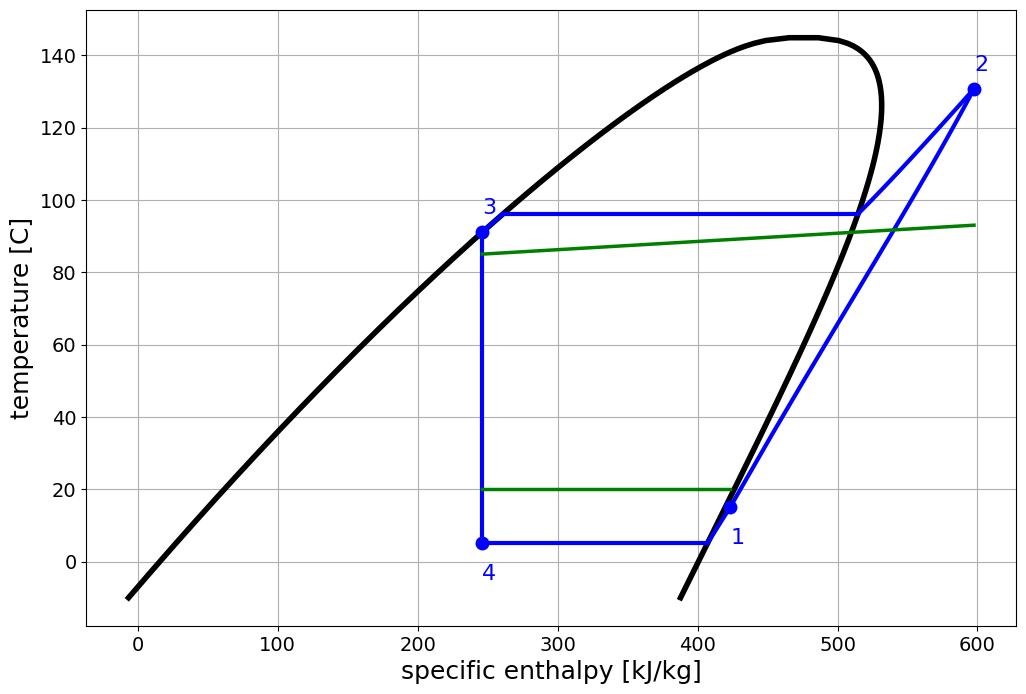

In [79]:
Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)